# Aproksymacja splinami minimalizowana ze względu na wariancję.

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as signal
from scipy.interpolate import make_lsq_spline, BSpline
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep
import seaborn as sns

from core import *

In [5]:
spline_order = 2
approx_acc = 5e-5

In [6]:
test_data = TestData()

data = test_data.data[:1200]
x_data = [i for i in range(len(data))]
y_data = [values[1][0] for values in data]

all_data = test_data.data
x_all_data = [i for i in range(len(all_data))]
y_all_data = [values[1][0] for values in all_data]


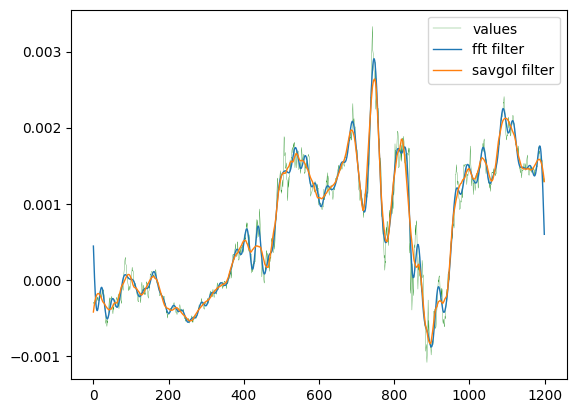

In [143]:
class Savgol_filter:
    def __init__(self, window=50, order=2):
        self.window = window
        self.order = order

    def filter(self, values):
        return signal.savgol_filter(values, self.window, self.order)
    
class Fft_lowpass_filter:
    def __init__(self, cutoff=0.05):
        self.cutoff = cutoff

    def filter(self, values):
        value_fft = np.fft.fft(value)
        frequencies = np.fft.fftfreq(len(value_fft), 1)
        value_fft[np.abs(frequencies) > self.cutoff] = 0
        return np.fft.ifft(value_fft).real


limits = (0,1200)
shift = 0
data = all_data[limits[0] + shift: limits[1] + shift]
fs = 1

time = [i + shift for i in range(len(data))]
value = [values[1][0] for values in data]

fft_lowpass_filter = Fft_lowpass_filter(0.04)
filtered_fft = fft_lowpass_filter.filter(value)

savgol_filter = Savgol_filter(window=50, order=3)
filtered_savgol = savgol_filter.filter(value)

plt.plot(time, value, label='values', color='green', linewidth=0.2)
plt.plot(time, filtered_fft, label='fft filter', linewidth=1)
plt.plot(time, filtered_savgol, label='savgol filter', linewidth=1)

plt.legend()
plt.show()

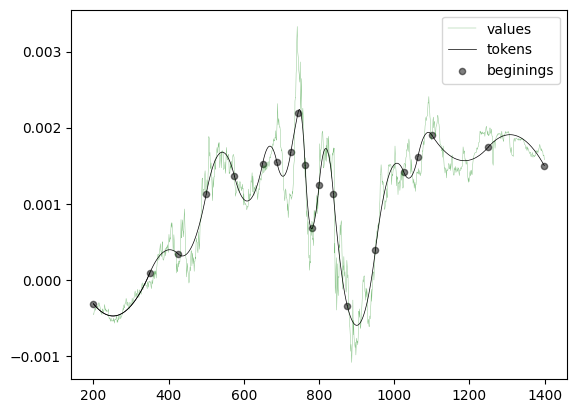

4.7e-06
1.6e-06


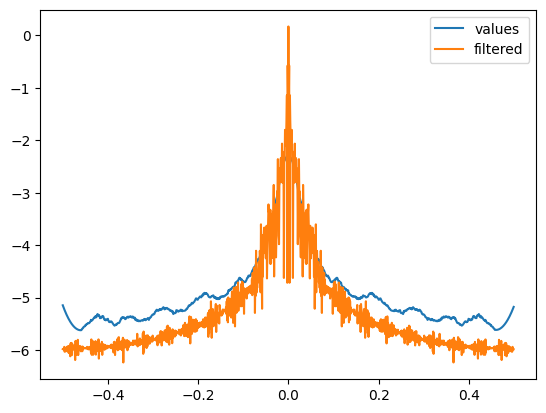

In [131]:

def power_spectrum(values, freq=0, filter=False):
    if values is None:
        return None, None, None
    ps = np.abs(np.fft.fft(values))**2
    freqs = np.fft.fftfreq(len(values), d=1)
    idx = np.argsort(freqs)
    freqencies = freqs[idx]
    log_powers = [math.log10(p) for p in ps[idx]] 
    log_powers_filtered = signal.savgol_filter(log_powers, 100, 2)
    for i in range(len(freqencies)):
        if freqencies[i] > - math.fabs(freq):
            log_power = log_powers_filtered[i]
            break

    if filter:
        log_powers = log_powers_filtered
    return freqencies, log_powers, 10 ** log_power

filter = Savgol_filter(window=50, order=2)

def splines(limits=(0,1200), shift=0,
            filter=filter,
            k=spline_order, s=approx_acc):

    data = all_data[limits[0] + shift: limits[1] + shift]
    time = [i + shift for i in range(len(data))]
    value = [values[1][0] for values in data]
      
    filtered = None
    if filter is None:
        bspl = splrep(time, value, k=k, s=s)
    else:
        filtered = filter.filter(value)
        bspl = splrep(time, filtered, k=k, s=s)

    poly = scipy.interpolate.PPoly.from_spline(bspl)
    coefs = poly.c.T 
    knots = poly.x
    intervals = [((knots[i], knots[i+1]), coefs[i]) for i in range(k, len(knots) - (k))]
    
    return intervals, time, value, filtered

def plot_splines(intervals=None, time=None, value=None, filtered=None, color='black', show=True):

    if (time is not None) and (value is not None):
        plt.plot(time, value, label='values', color='green', linewidth=0.3, alpha=0.5)
    if (time is not None) and (filtered is not None):
        plt.plot(time, filtered, label='filtered', color='blue', linewidth=5, alpha=0.3) 

    if intervals is not None:
        _xx = []
        _yy = []
        first = True
        for interval in intervals:
            polynomial = np.poly1d(interval[1])
            _xx.append(interval[0][0])
            _yy.append(polynomial(0))

            xx = [_ for _ in range(int(interval[0][0]), int(interval[0][1]) + 1)]
            yy = [polynomial(_ - interval[0][0]) for _ in xx]
            if first:
                plt.plot(xx, yy, label='tokens', linewidth=0.5, color=color, alpha=1)
                first = False
            plt.plot(xx, yy, linewidth=0.5, color=color, alpha=1)
        
        plt.scatter(_xx, _yy, label='beginings', color=color, marker='o', s=20, alpha=0.5)
    
    if not show:
        return
    if ((value is not None) and (time is not None)) or (filtered is not None) or (intervals is not None):
        plt.legend()
        plt.show()    

intervals, time, value, filtered = splines(
    limits=(0,1200), shift=200,
    k=2, s=5e-5
    )
plot_splines(intervals, time, value)

freqencies, log_powers, power = power_spectrum(value, freq=0.3, filter=True)
if freqencies is not None:
    print(f'{power:1.1e}')
    plt.plot(freqencies, log_powers, label='values')

freqencies, log_powers, power = power_spectrum(filtered, freq=0.3, filter=False)
if freqencies is not None:
    print(f'{power:1.1e}')
    plt.plot(freqencies, log_powers, label='filtered')

plt.legend()
plt.show()

In [8]:
tck_all_data = splrep(x_data, y_data, k=spline_order, s=approx_acc)

(array([  27,   51,  122,  295,  320,  356,  431,  434,  449,  507,  578,
        641,  643,  686,  688,  715,  797,  803,  814,  887,  921,  943,
        945, 1001, 1069, 1136, 1152, 1156, 1161, 1173], dtype=int64),)
(array([  25,   30,  121,  155,  305,  345,  358,  433,  438,  502,  517,
        610,  642,  683,  687,  689,  794,  802,  805,  815,  892,  933,
        944,  946, 1056, 1082, 1138, 1155, 1160, 1171, 1174], dtype=int64),)


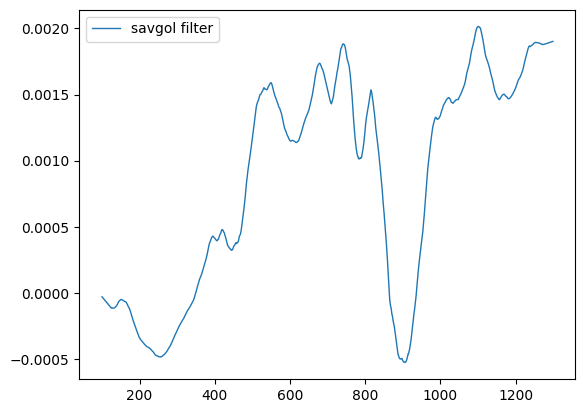

In [100]:
from scipy.signal import argrelextrema

limits = (0,1200)
shift = 100
data = all_data[limits[0] + shift: limits[1] + shift]
fs = 1

time = [i + shift for i in range(len(data))]
value = [values[1][0] for values in data]

savgol_filter = Savgol_filter(window=50, order=1)
filtered_savgol = savgol_filter.filter(value)

# for local maxima
print(argrelextrema(filtered_savgol, np.greater))

# for local minima
print(argrelextrema(filtered_savgol, np.less))

# plt.plot(time, value, label='values', color='green', linewidth=0.2)
plt.plot(time, filtered_savgol, label='savgol filter', linewidth=1)

plt.legend()
plt.show()


## Czy tokenizacja jest stabilna.

Ustalamy doświadczalnie okres czasu przeszłego stanowiący context decyzji: tokeny z tego okresu zasilają procesor AI. Nie chcemy żeby ten ciąg tokenów zmieniał się nie tylko przez przesunięcie końców - ewoluował wewnętrz tego okresu obserwacji.

Widzieliśmy już przypadek takiej niestabilności: gdy rysowaliśmy zęby piły na wykresie. Ta niestabilność wynika z lokalności metody określania końców tokenów. Tak samo ograniczanie w miejscach relatywnej 'stabilizacji' prowadzi do niestabilności bo dwa podobne miejsca na wykresie mogą być inaczej tokenizowane przy infinizymalnej różnicy 'stabilizacji'.


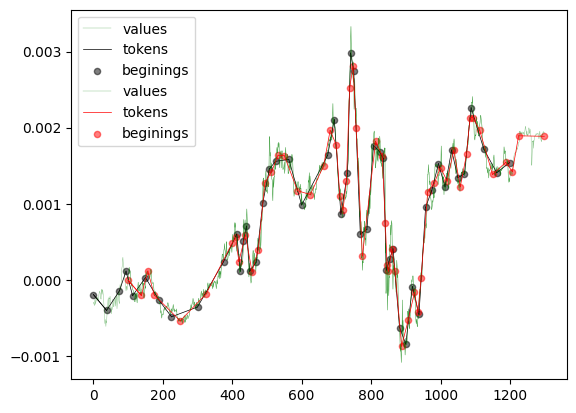

In [141]:
def is_parsing_stable():
    k = 1
    s = 1e-5
    limits = (0,1200)
    intervals, time, value, filtered = splines(
        limits=limits, shift=0,
        k=k, s=s
        )
    plot_splines(intervals, time, value, show=False)

    intervals, time, value, filtered = splines(
        limits=limits, shift=100,
        k=k, s=s
        )    
    plot_splines(intervals, time, value, color='red', show=False)

    # intervals, time, value, filtered = splines(
    #     limits=limits, shift=200,
    #     k=k, s=s
    #     )    
    # plot_splines(intervals, time, value, color='blue', show=False)    

    plt.legend()
    plt.show()

is_parsing_stable() 



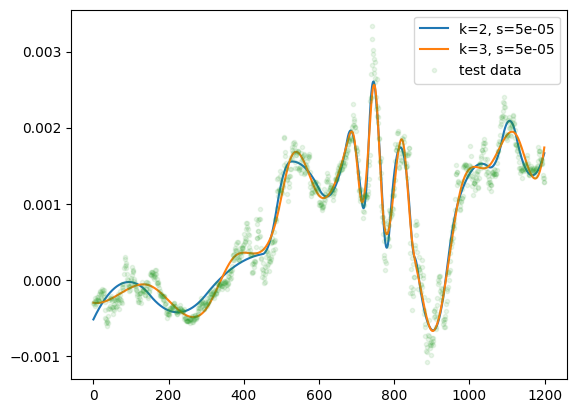

In [105]:
def spline_choice(k=spline_order, s=approx_acc):
    tck = splrep(x_data, y_data, s=s, k=k)
    plt.plot(x_data, BSpline(*tck)(x_data), '-', label=f'k={k}, s={s}')

spline_choice()
spline_choice(k=3)
plt.plot(x_data, y_data, '.', alpha=0.1, label='test data')
plt.legend()
plt.show()

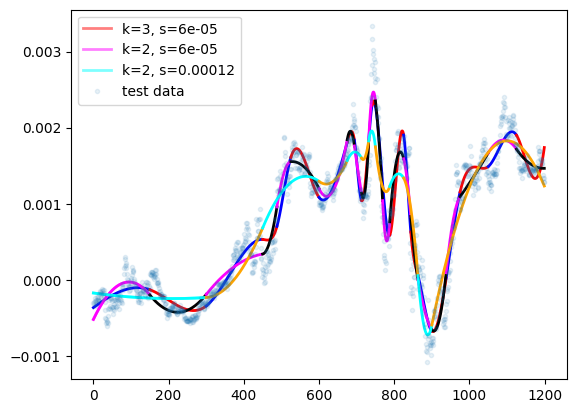

In [151]:
s = 0.00006
k = 2
linewidth = 2

def tokens(k=k, s=s, colors=('red', 'blue')):
    tck = splrep(x_data, y_data, s=s, k=k)
    poly = scipy.interpolate.PPoly.from_spline(tck)
    coefs = poly.c.T 
    knots = poly.x
    intervals = [((knots[i], knots[i+1]), coefs[i]) for i in range(2, len(knots) - 2 * 2 + 1)]
    color = True
    first = 1
    for interval in intervals:
        color = not color
        polynomial = np.poly1d(interval[1])
        x = [_ for _ in range(int(interval[0][0]), int(interval[0][1]) + 1)]
        y = [polynomial(_ - interval[0][0]) for _ in x]
        if first:
            first -= 1
            plt.plot(x, y, label=f'k={k}, s={s}', color=colors[int(color)], linewidth=linewidth, alpha=0.5)
        
        plt.plot(x, y, color=colors[int(color)], linewidth=linewidth, alpha=1)

tokens(k=3)
tokens(k=2, colors=('magenta', 'black'))
tokens(k=2, s=2*s, colors=('cyan', 'orange'))
plt.plot(x_data, y_data, '.', alpha=0.1, label='test data')
plt.legend()
plt.show()


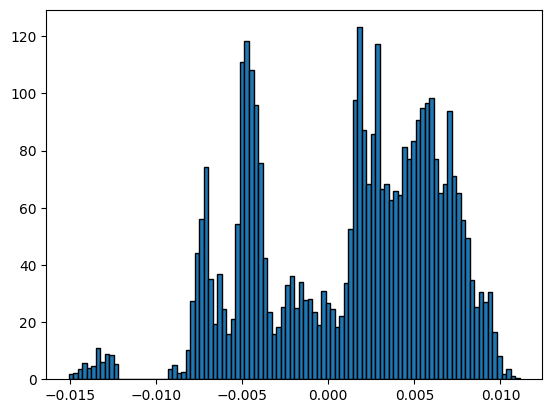

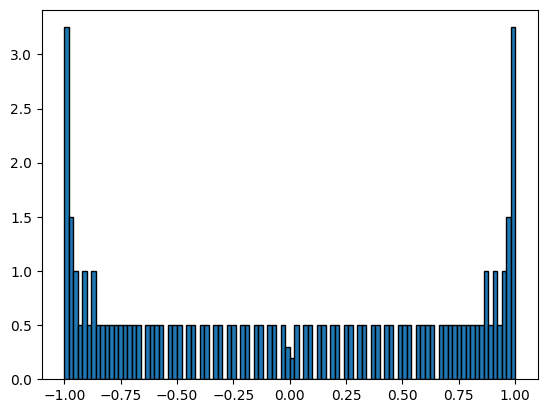

In [135]:
hist_data = [values[1][0] for values in all_data]
plt.hist(hist_data, bins=100, edgecolor='black', density=True)
plt.show()

sin_data = [math.sin(math.pi * n * 0.01) for n in range(5000)]
plt.hist(sin_data, bins=100, edgecolor='black', density=True)
plt.show()